In [2]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [3]:
!ls "/content/drive/MyDrive/Colab Notebooks/FinprosTest2"

FPT.csv  MSN.csv  PNJ.csv  VIC.csv


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
# from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Dropout

In [5]:
codeList = ['FPT', 'MSN', 'PNJ', 'VIC']
df = {}
for i in codeList:
  df[i] = pd.read_csv(f"/content/drive/MyDrive/Colab Notebooks/FinprosTest2/{i}.csv")
  print(df[i].head(5))
  print(df[i].shape)


  Ticker        Date/Time   Open   High    Low  Close  Volume  Open Interest
0    FPT  12/25/2018 9:15  30.89  30.89  30.89  30.89   35410              0
1    FPT  12/25/2018 9:16  30.81  30.81  30.81  30.81     190              0
2    FPT  12/25/2018 9:17  30.74  30.81  30.74  30.74    1120              0
3    FPT  12/25/2018 9:18  30.74  30.74  30.74  30.74    2120              0
4    FPT  12/25/2018 9:19  30.74  30.74  30.74  30.74   22500              0
(97406, 8)
  Ticker        Date/Time  Open  High   Low  Close  Volume  Open Interest
0    MSN  12/25/2017 9:15  73.1  73.1  73.1   73.1    4210              0
1    MSN  12/25/2017 9:16  73.0  73.0  73.0   73.0    5000              0
2    MSN  12/25/2017 9:18  73.5  73.5  73.5   73.5     210              0
3    MSN  12/25/2017 9:20  73.2  73.5  73.1   73.1    2050              0
4    MSN  12/25/2017 9:21  73.0  73.0  73.0   73.0    1380              0
(135354, 8)
  Ticker       Date/Time   Open   High    Low  Close  Volume  Open Inte

In [6]:
for i in codeList:
  print(i)
  print(df[i].info())

FPT
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97406 entries, 0 to 97405
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Ticker         97406 non-null  object 
 1   Date/Time      97406 non-null  object 
 2   Open           97406 non-null  float64
 3   High           97406 non-null  float64
 4   Low            97406 non-null  float64
 5   Close          97406 non-null  float64
 6   Volume         97406 non-null  int64  
 7   Open Interest  97406 non-null  int64  
dtypes: float64(4), int64(2), object(2)
memory usage: 5.9+ MB
None
MSN
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135354 entries, 0 to 135353
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Ticker         135354 non-null  object 
 1   Date/Time      135354 non-null  object 
 2   Open           135354 non-null  float64
 3   High           135354 non-null  float

In [7]:
for i in codeList:
  df[i]['Date/Time'] =pd.to_datetime(df[i]['Date/Time'])

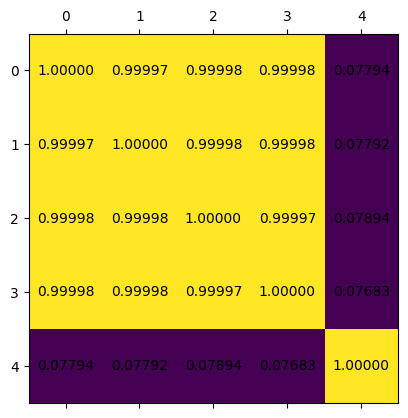

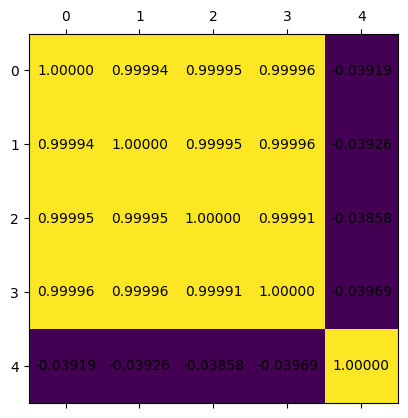

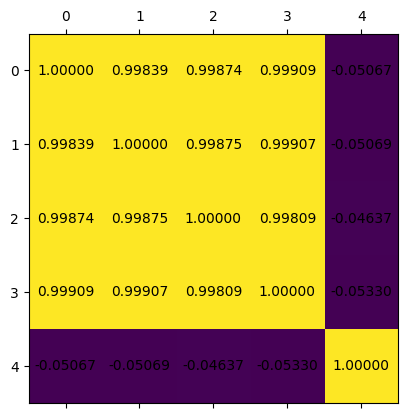

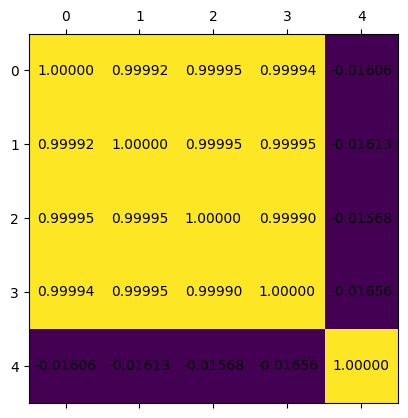

In [8]:
for i in codeList:
  data = df[i][['Close', 'Open', 'High', 'Low', 'Volume']].corr()
  fig, ax = plt.subplots()
  ax.matshow(data)
  for (i, j), z in np.ndenumerate(data):
    ax.text(j, i, '{:0.5f}'.format(z), ha='center', va='center')


In [9]:
scalerList = {}
for i in codeList:
  scaler = MinMaxScaler(feature_range=(0,1))
  temp = df[i]['Close'].values.reshape(-1,1)
  df[i]['Close_scaled'] = scaler.fit_transform(temp)
  scalerList[i] = scaler

In [10]:
test_date = "12/01/2020"
training_set, test_set = {}, {}
for i in codeList:
  training_set[i] = df[i][df[i]['Date/Time']<test_date]
  test_set[i] = df[i][df[i]['Date/Time']>=test_date]

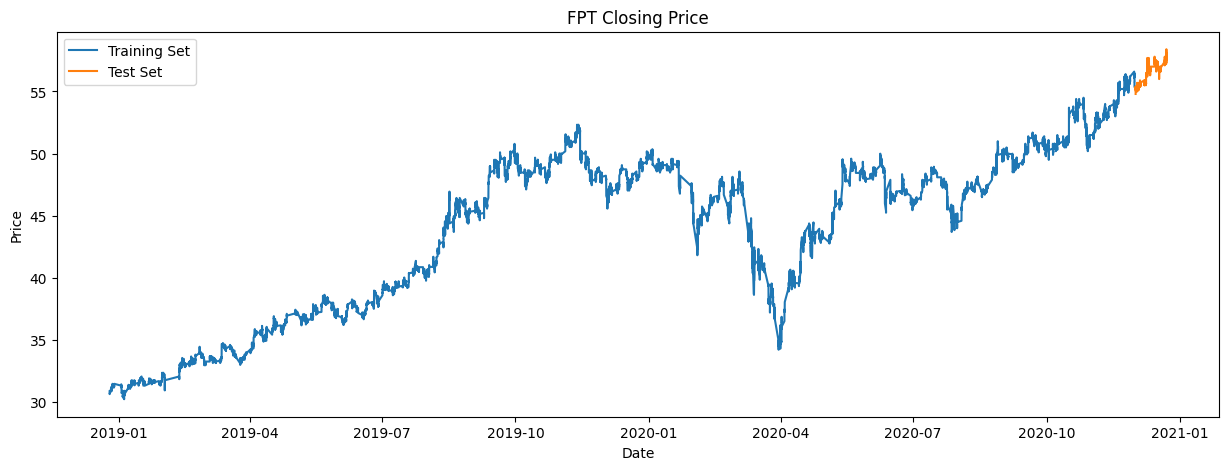

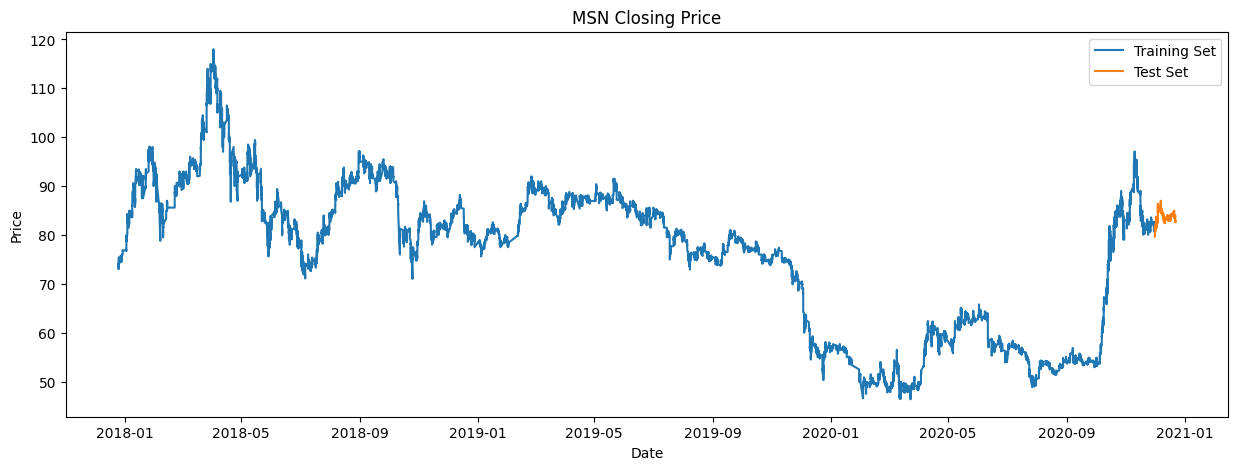

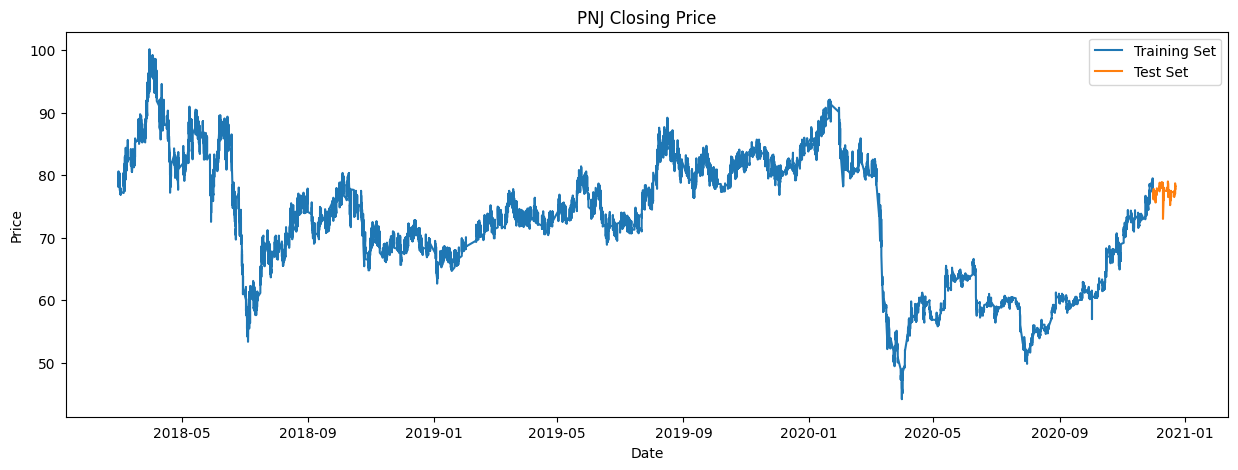

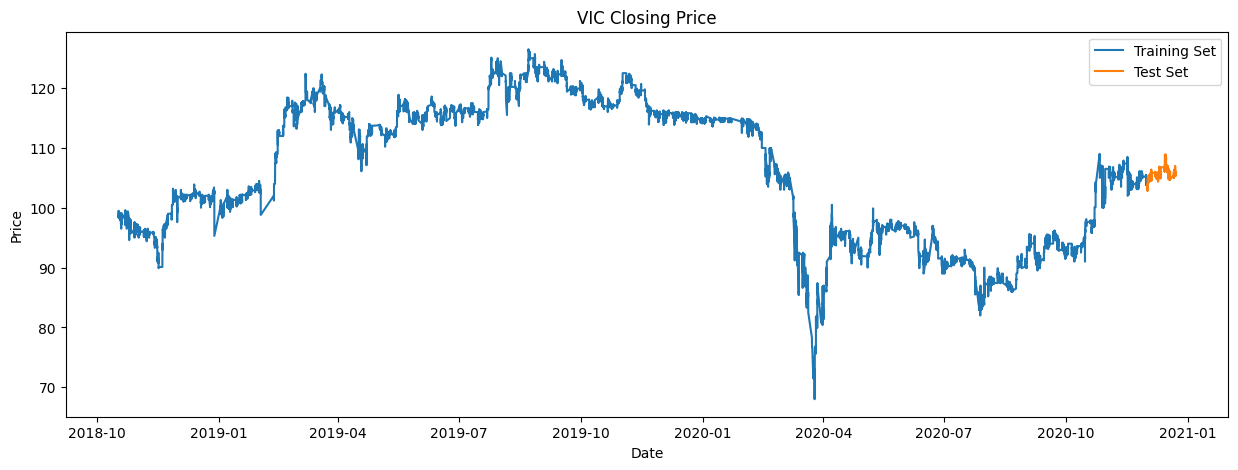

In [11]:
for i in codeList:
  plt.figure(figsize=(15,5))
  plt.plot(training_set[i]['Date/Time'], training_set[i]['Close'])
  plt.plot(test_set[i]['Date/Time'], test_set[i]['Close'])
  plt.xlabel("Date")
  plt.ylabel("Price")
  plt.legend(['Training Set', 'Test Set'])
  plt.title(f"{i} Closing Price")

### Preprocesing

In [12]:
print(training_set['FPT'][['Close', 'Close_scaled']])

       Close  Close_scaled
0      30.89      0.022735
1      30.81      0.019893
2      30.74      0.017407
3      30.74      0.017407
4      30.74      0.017407
...      ...           ...
94015  56.10      0.918295
94016  55.90      0.911190
94017  55.80      0.907638
94018  55.80      0.907638
94019  55.40      0.893428

[94020 rows x 2 columns]


In [13]:
def transform_input(df, time_steps):
  df_np = np.array(df['Close_scaled'])
  X = []
  y = []
  for i in range(len(df_np)-time_steps):
    row = [[j] for j in df_np[i:i+time_steps]]
    X.append(row)
    y.append(df_np[i+time_steps])
  X = np.array(X)
  y = np.array(y)
  return X, y

In [14]:
trainset, testset= {}, {}
time_steps = 60
for i in codeList:
  trainset[i], testset[i] = {}, {}
  trainset[i]['X'], trainset[i]['y'] = transform_input(training_set[i], time_steps)
  testset[i]['X'], testset[i]['y'] = transform_input(test_set[i], time_steps)
  print(f"{i}: Train-{trainset[i]['X'].shape} {trainset[i]['y'].shape}")
  print(f"     Test -{testset[i]['X'].shape} {testset[i]['y'].shape}")

FPT: Train-(93960, 60, 1) (93960,)
     Test -(3326, 60, 1) (3326,)
MSN: Train-(131962, 60, 1) (131962,)
     Test -(3272, 60, 1) (3272,)
PNJ: Train-(122203, 60, 1) (122203,)
     Test -(2986, 60, 1) (2986,)
VIC: Train-(97894, 60, 1) (97894,)
     Test -(3252, 60, 1) (3252,)


### Building LSTM model

In [15]:
%%time
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(time_steps, 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')

if os.path.exists("/content/drive/MyDrive/Colab Notebooks/FinprosTest_model.keras"):
  model = load_model("/content/drive/MyDrive/Colab Notebooks/FinprosTest_model.keras")
else:
  for i in codeList:
    print("Fitting to", i)
    model.fit(trainset[i]["X"], trainset[i]["y"], epochs=10, batch_size=32)
  model.save("FinprosTest_model.keras")

CPU times: user 2.43 s, sys: 195 ms, total: 2.63 s
Wall time: 4.51 s


3060/3060 [==============================] - 18s 6ms/step


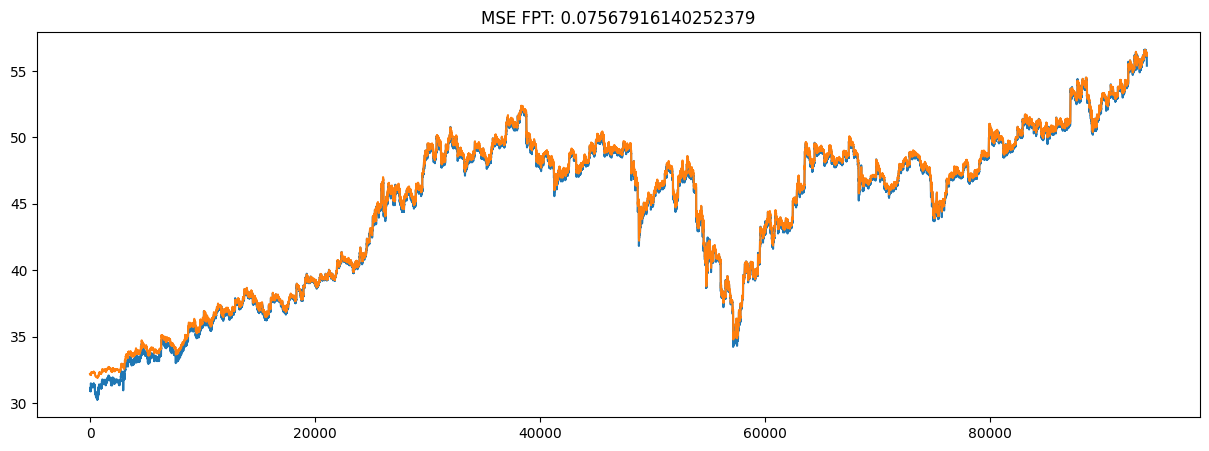

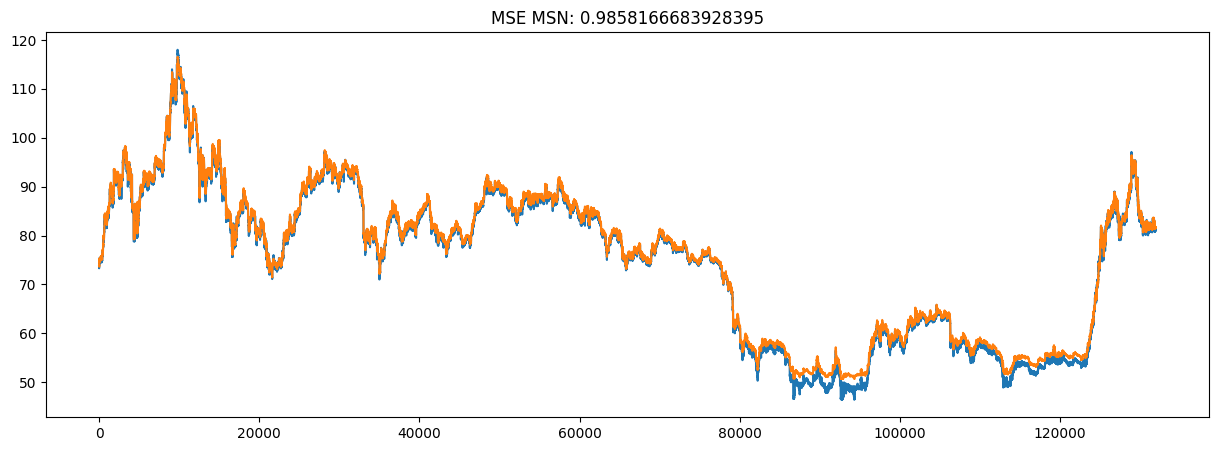

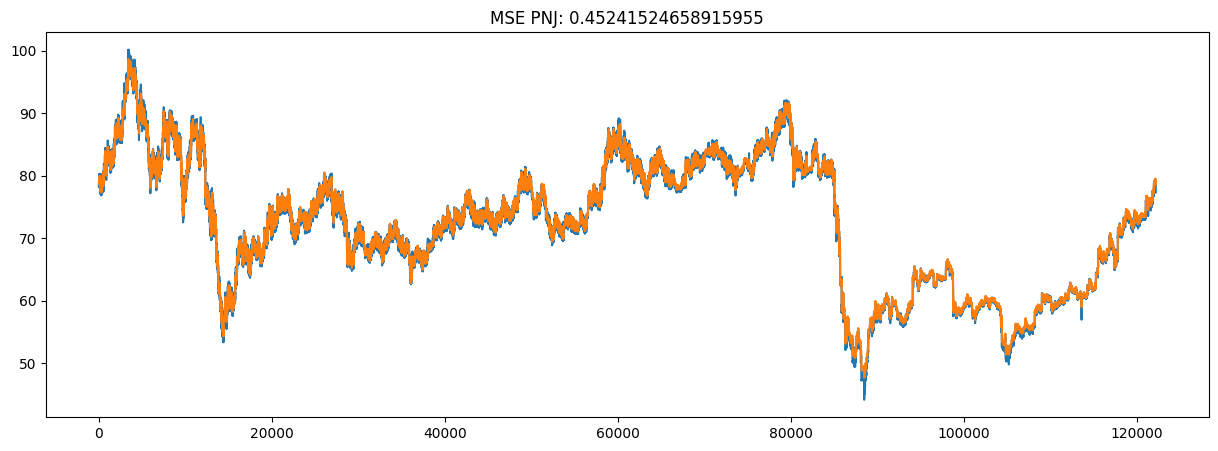

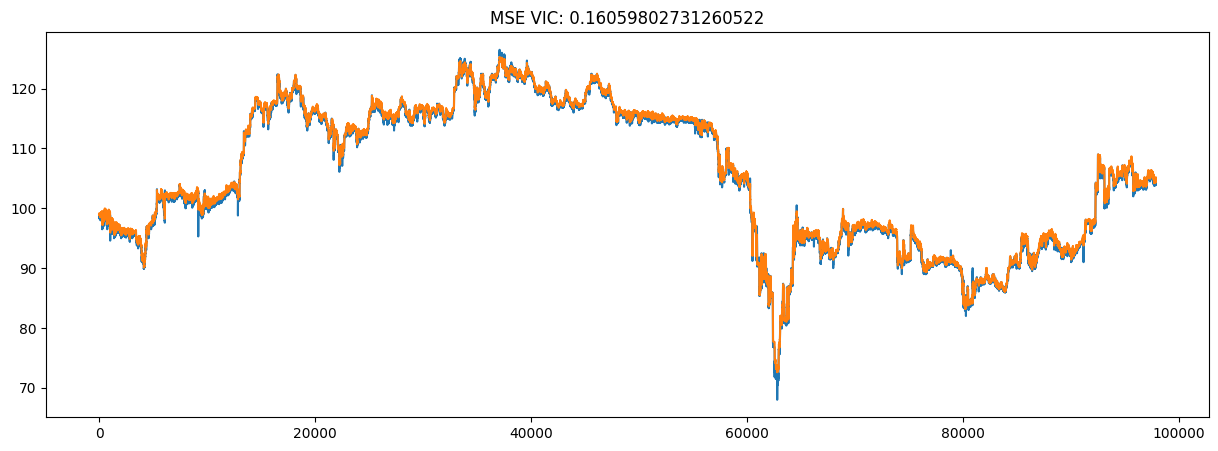

In [64]:
for i in codeList:
  y_true = scalerList[i].inverse_transform(trainset[i]['y'].reshape(-1,1))
  y_pred = scalerList[i].inverse_transform(model.predict(trainset[i]["X"]))
  mse = mean_squared_error(y_true, y_pred)
  plt.figure(figsize=(15,5))
  plt.plot(y_true)
  plt.plot(y_pred)
  plt.title(f"MSE {i}: {mse}")

102/102 [==============================] - 1s 5ms/step


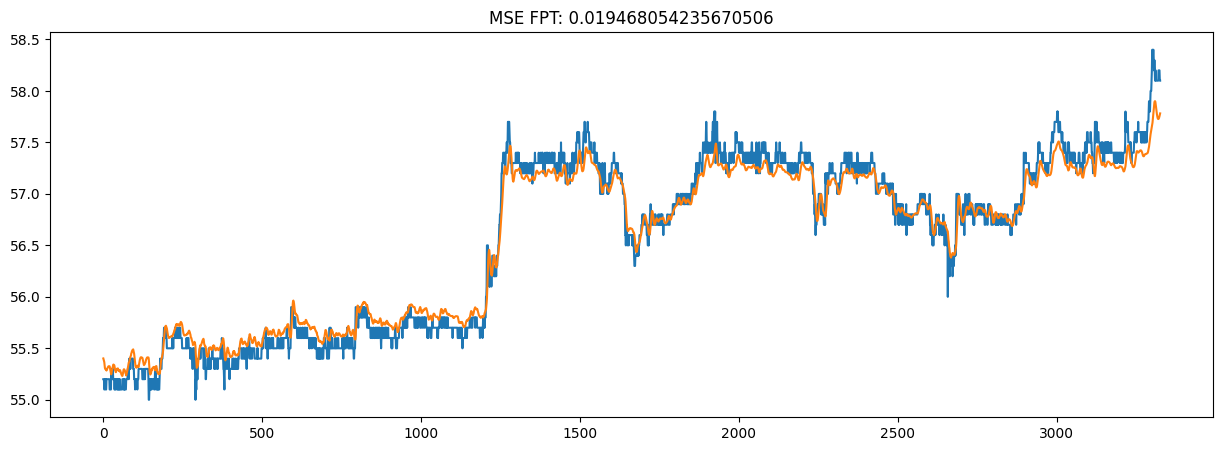

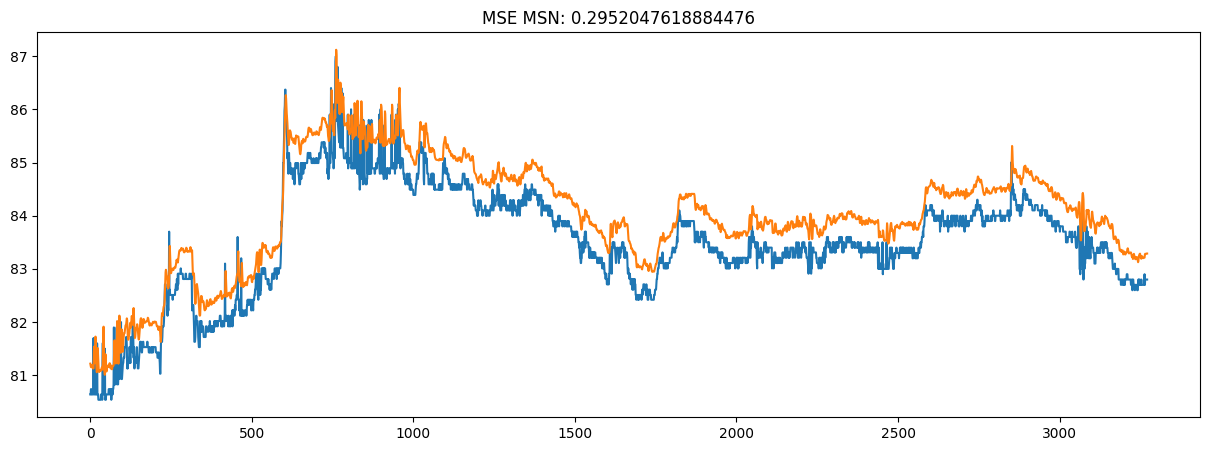

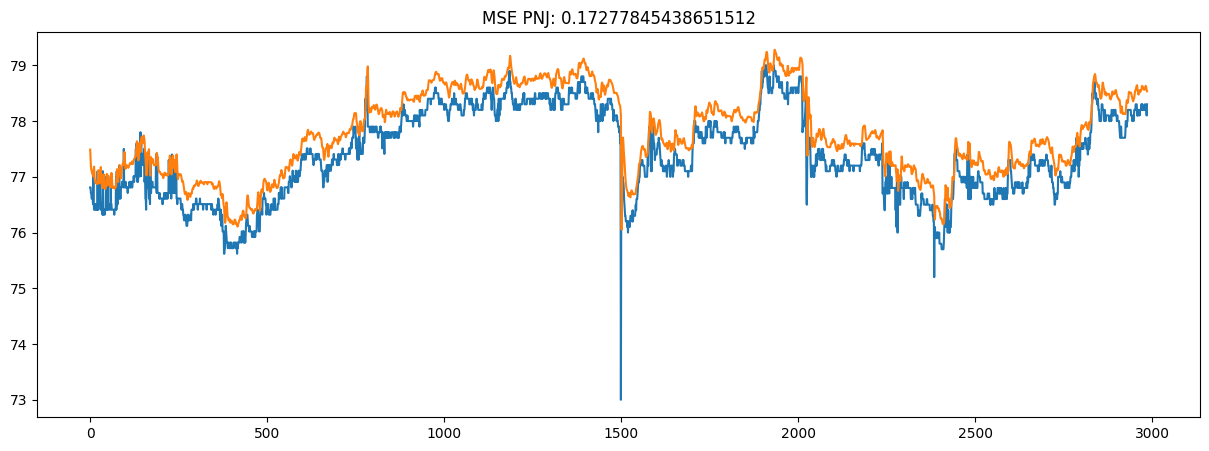

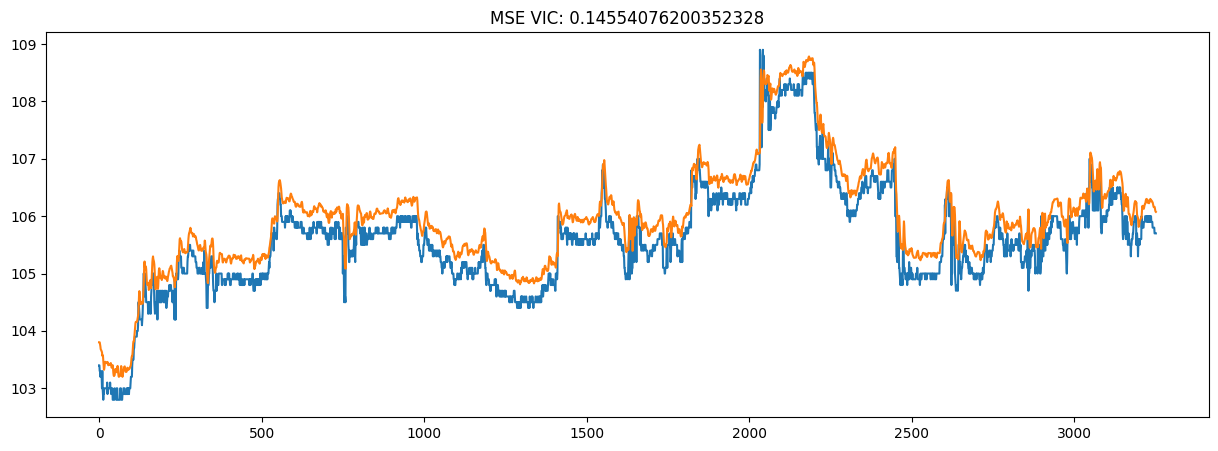

In [16]:
for i in codeList:
  y_true = scalerList[i].inverse_transform(testset[i]['y'].reshape(-1,1))
  y_pred = scalerList[i].inverse_transform(model.predict(testset[i]["X"]))
  mse = mean_squared_error(y_true, y_pred)
  plt.figure(figsize=(15,5))
  plt.plot(y_true)
  plt.plot(y_pred)
  plt.title(f"MSE {i}: {mse}")

Model need to select the right Scaler before inverse for better accuracy prediction, otherwise, it will return bad predict.

**Thus, need to know which Stock are predicted to.**

In [18]:
print(scalerList['FPT'].inverse_transform(model.predict(temp)))
print(scalerList['VIC'].inverse_transform(model.predict(temp)))

1/1 [==============================] - 0s 21ms/step
[[55.401447]
 [55.39146 ]]
1/1 [==============================] - 0s 20ms/step
[[120.268555]
 [120.247795]]


In [61]:
def fluctuation_pred(arr, n_steps, y_true, code, n_features=1):
  n = 0
  res = []
  arr_ = arr
  while n < n_steps:
    # print(arr_)
    pred_value = model.predict(arr_)
    value = scalerList[code].inverse_transform(pred_value)
    res = np.append(res,float(y_true - value))
    arr_ = arr_[0,1:,0]
    arr_ = np.append(arr_,float(pred_value))
    arr_ = arr_.reshape(1,arr_.shape[0],n_features)
    # print(arr_)
    # print(pred_value)
    n+=1
  return res

In [51]:
n_steps = 100
n_features = 1
value_changes = {}
multi_pred = {}

for i in codeList:
  multi_pred[i] = testset[i]['X'][-1]
  multi_pred[i] = multi_pred[i].reshape(1,multi_pred[i].shape[0],multi_pred[i].shape[1])

for i in codeList:
  # if i == 'MSN':
  #   break
  y_true = scalerList[i].inverse_transform(testset[i]['y'].reshape(-1,1))[-1]

  value_changes[i] = fluctuation_pred(multi_pred[i], n_steps, y_true, i)

1/1 [==============================] - 0s 20ms/step


**1 steps = 15mins in trading session**

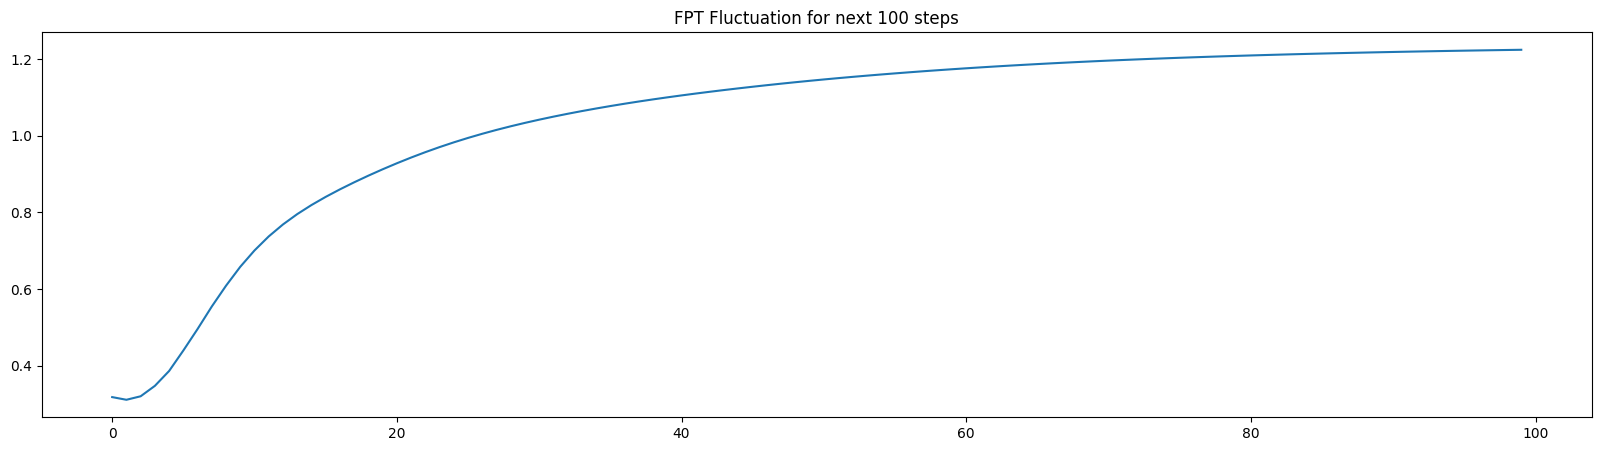

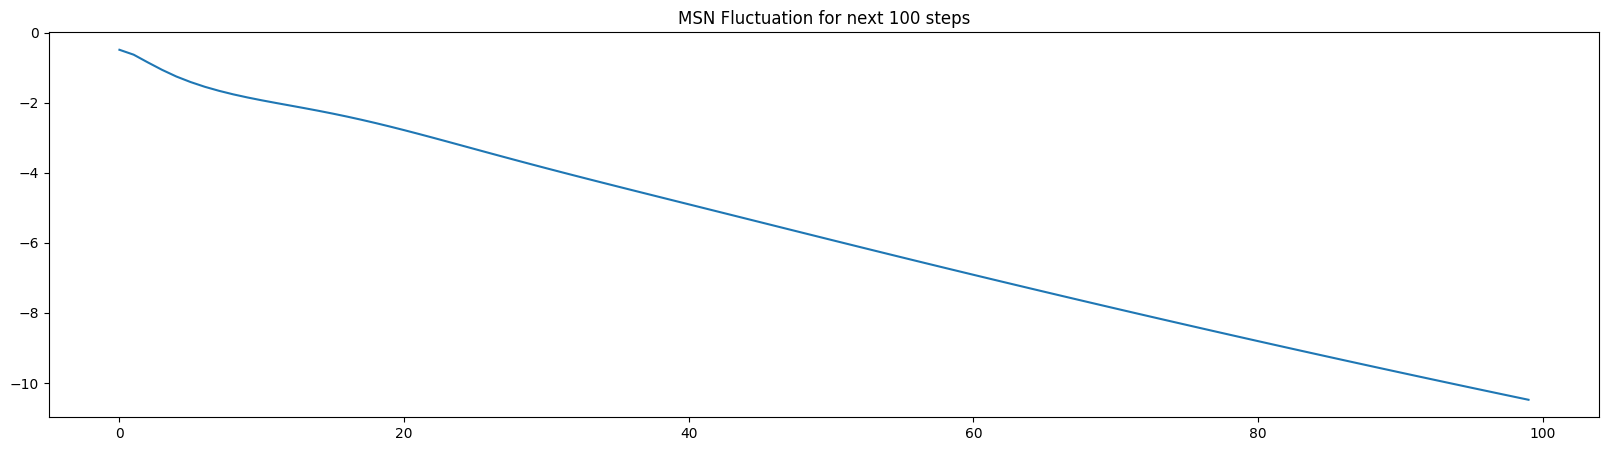

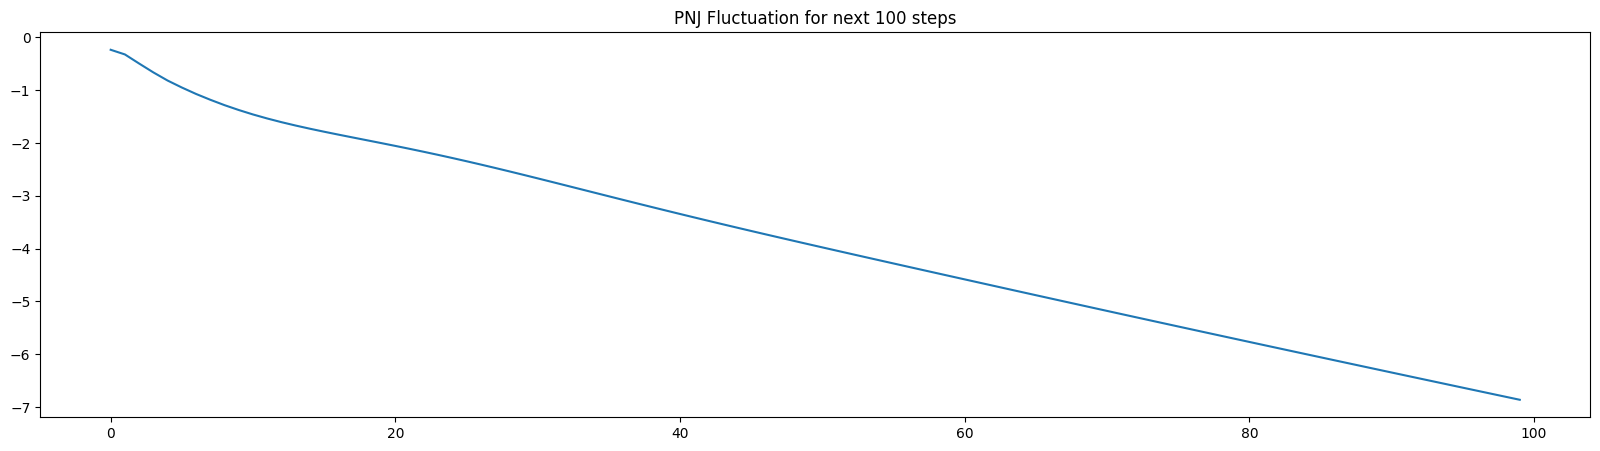

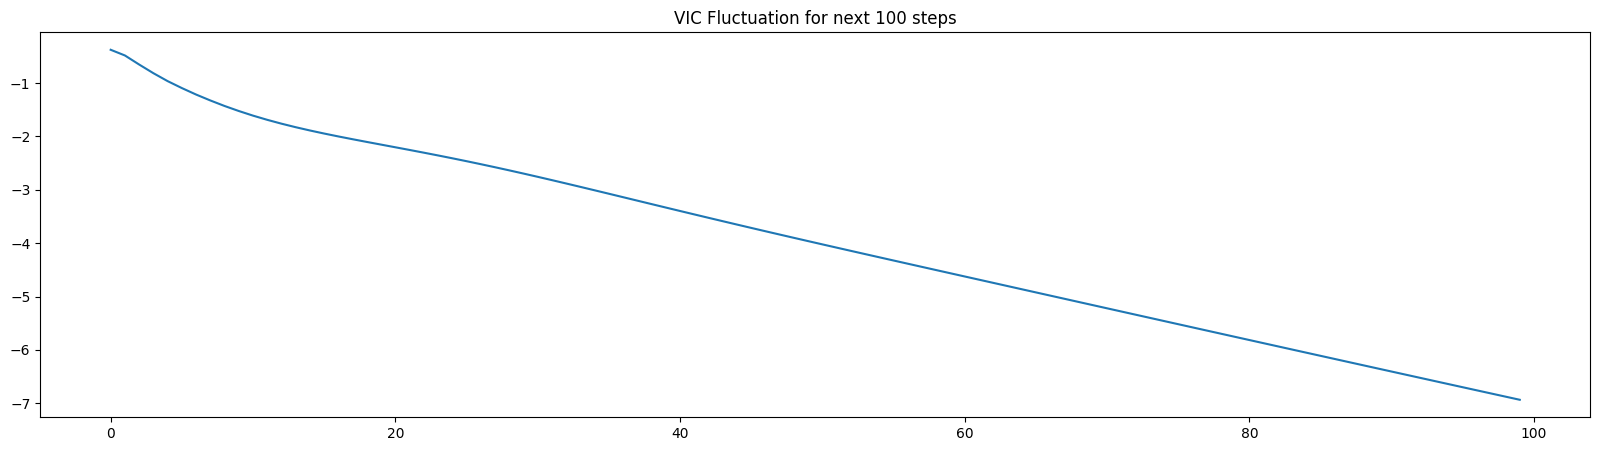

In [52]:
for i in codeList:
  plt.figure(figsize=(20,5))
  plt.plot(value_changes[i])
  # plt.xticks()
  plt.title(f"{i} Fluctuation for next {n_steps_after} steps")

1/1 [==============================] - 0s 20ms/step


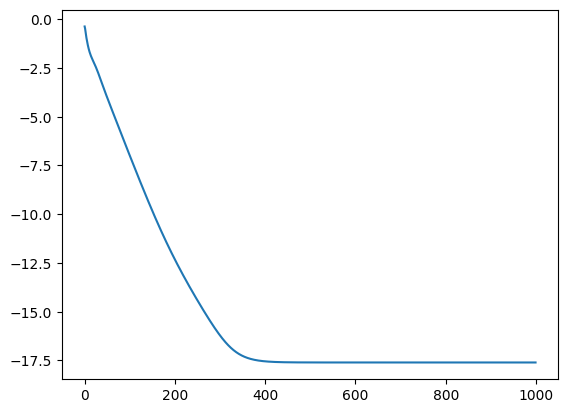

In [63]:
y_true_temp = scalerList['VIC'].inverse_transform(testset['VIC']['y'].reshape(-1,1))[-1]
test_ = testset[i]['X'][-1]
test_ = test_.reshape(1,test_.shape[0], test_.shape[1])
temp_ = fluctuation_pred(test_, 1000, y_true_temp, code="VIC")
plt.plot(temp_)